# 執行模式

In [66]:
sc.master

u'local[*]'

# 資料準備

In [67]:
#讀取資料
global Path    
if sc.master[0:5]=="local" :
   Path="file:/home/hduser/pythonsparkexample/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"

In [68]:
#觀察資料型態
#Name無用, Sex and Embraked需要轉換成數值, Age and Cabin轉成float, ,SibSp and Parch有參考價值
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"data/train.csv")
rawDataWithHeader.take(2)
#發現年紀有部份資料為空

開始匯入資料...


[u'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked',
 u'1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S']

In [69]:
#將資料整理成label與特徵欄位
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"data/train.csv")
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)
lines = rawData.map(lambda x: x.split(","))
newline = lines.map(lambda x: x[:3]+x[5:11]+[x[-1]])
print("共計：" + str(lines.count()) + "筆")
newline.take(10)

開始匯入資料...
共計：891筆


[[u'1', u'0', u'3', u'male', u'22', u'1', u'0', u'A/5 21171', u'7.25', u'S'],
 [u'2',
  u'1',
  u'1',
  u'female',
  u'38',
  u'1',
  u'0',
  u'PC 17599',
  u'71.2833',
  u'C'],
 [u'3',
  u'1',
  u'3',
  u'female',
  u'26',
  u'0',
  u'0',
  u'STON/O2. 3101282',
  u'7.925',
  u'S'],
 [u'4', u'1', u'1', u'female', u'35', u'1', u'0', u'113803', u'53.1', u'S'],
 [u'5', u'0', u'3', u'male', u'35', u'0', u'0', u'373450', u'8.05', u'S'],
 [u'6', u'0', u'3', u'male', u'', u'0', u'0', u'330877', u'8.4583', u'Q'],
 [u'7', u'0', u'1', u'male', u'54', u'0', u'0', u'17463', u'51.8625', u'S'],
 [u'8', u'0', u'3', u'male', u'2', u'3', u'1', u'349909', u'21.075', u'S'],
 [u'9', u'1', u'3', u'female', u'27', u'0', u'2', u'347742', u'11.1333', u'S'],
 [u'10',
  u'1',
  u'2',
  u'female',
  u'14',
  u'1',
  u'0',
  u'237736',
  u'30.0708',
  u'C']]

In [70]:
AgeMap= newline.map(lambda x:x[4]).distinct().zipWithIndex().collectAsMap()
items = list(AgeMap.items())
print(items)
#部份資料為空

[(u'', 0), (u'0.42', 1), (u'24', 2), (u'25', 3), (u'26', 4), (u'27', 5), (u'20', 6), (u'21', 7), (u'22', 8), (u'23', 9), (u'28', 10), (u'29', 11), (u'4', 12), (u'8', 13), (u'45.5', 14), (u'14.5', 15), (u'59', 16), (u'58', 17), (u'55', 18), (u'24.5', 19), (u'57', 20), (u'56', 21), (u'51', 22), (u'50', 23), (u'53', 24), (u'52', 25), (u'54', 26), (u'55.5', 27), (u'34.5', 28), (u'36.5', 29), (u'80', 30), (u'20.5', 31), (u'3', 32), (u'7', 33), (u'40.5', 34), (u'39', 35), (u'38', 36), (u'33', 37), (u'32', 38), (u'31', 39), (u'30', 40), (u'37', 41), (u'36', 42), (u'35', 43), (u'34', 44), (u'23.5', 45), (u'32.5', 46), (u'71', 87), (u'60', 48), (u'61', 49), (u'62', 50), (u'63', 51), (u'64', 52), (u'65', 53), (u'66', 54), (u'0.83', 55), (u'2', 56), (u'6', 57), (u'28.5', 58), (u'11', 59), (u'10', 60), (u'13', 61), (u'12', 62), (u'15', 63), (u'14', 64), (u'17', 65), (u'16', 66), (u'19', 67), (u'18', 68), (u'0.92', 69), (u'30.5', 70), (u'0.67', 71), (u'48', 72), (u'49', 73), (u'46', 74), (u'47', 75

In [71]:
notnull = newline.map(lambda x: len(x[4])!=0).sum()
#去除年紀無資料的欄位
noNull = newline.filter(lambda x: len(x[4])!=0)
AgeSum = noNull.map(lambda x: x[4]).collect()
x = 0
for a in AgeSum:
    x += float(a)
AgeAver = x/notnull
print(AgeAver)
newlines = newline.map(lambda x:  x[:4]+[str(AgeAver)]+x[5:] if len(x[4])==0 else x)
newlines.take(10)

29.6991176471


[[u'1', u'0', u'3', u'male', u'22', u'1', u'0', u'A/5 21171', u'7.25', u'S'],
 [u'2',
  u'1',
  u'1',
  u'female',
  u'38',
  u'1',
  u'0',
  u'PC 17599',
  u'71.2833',
  u'C'],
 [u'3',
  u'1',
  u'3',
  u'female',
  u'26',
  u'0',
  u'0',
  u'STON/O2. 3101282',
  u'7.925',
  u'S'],
 [u'4', u'1', u'1', u'female', u'35', u'1', u'0', u'113803', u'53.1', u'S'],
 [u'5', u'0', u'3', u'male', u'35', u'0', u'0', u'373450', u'8.05', u'S'],
 [u'6',
  u'0',
  u'3',
  u'male',
  '29.6991176471',
  u'0',
  u'0',
  u'330877',
  u'8.4583',
  u'Q'],
 [u'7', u'0', u'1', u'male', u'54', u'0', u'0', u'17463', u'51.8625', u'S'],
 [u'8', u'0', u'3', u'male', u'2', u'3', u'1', u'349909', u'21.075', u'S'],
 [u'9', u'1', u'3', u'female', u'27', u'0', u'2', u'347742', u'11.1333', u'S'],
 [u'10',
  u'1',
  u'2',
  u'female',
  u'14',
  u'1',
  u'0',
  u'237736',
  u'30.0708',
  u'C']]

In [72]:
#第三和第四欄為名字，無參考價值，Cabin亦無參考價值
lines.take(1)[0][3:5]

[u'"Braund', u' Mr. Owen Harris"']

In [73]:
#資料只包含標籤與特徵欄位
newline.take(1)

[[u'1', u'0', u'3', u'male', u'22', u'1', u'0', u'A/5 21171', u'7.25', u'S']]

In [74]:
categoriesMap = newlines.map(lambda x:x[-1]).distinct().zipWithIndex().collectAsMap()
categoriesMap

{u'': 1, u'C': 3, u'Q': 0, u'S': 2}

In [75]:
len(categoriesMap)

4

In [76]:
type(categoriesMap)

dict

In [77]:
#擷取特徵欄位Sex, Embarked
import numpy as np
#將Sex轉換為數值（male=1, female=0）
def genderIndex(x):
    if x=="male":
        return 1
    else:
        return 0
    
def convert_float(x):
    if x =="":
        return 0
    else:
        return float(x)
    
def embarkedIdx(x):
    if x[-1]=="C":
        return 1
    elif x[-1]=="Q":
        return 2
    else:
        return 3

#收集特徵
def extract_features(x):
    categoryFeatures = np.zeros(4)
    categoryFeatures[0] = genderIndex(x[3])
    if len(x[-1]) != 0:
        categoryFeatures[embarkedIdx(x)] = 1
    else:
        pass
    numericalFeatures=[x[2], convert_float(x[4]), x[5], x[6], convert_float(x[8])]
    return np.concatenate((categoryFeatures, numericalFeatures))
    
def extract_label(x):
    label = x[1]
    return float(label)

from pyspark.mllib.regression import LabeledPoint

labelpointRDD = newline.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [78]:
#將整理的資料儲存成labeledPointRDD
labelpointRDD.take(10)

[LabeledPoint(0.0, [1.0,0.0,0.0,1.0,3.0,22.0,1.0,0.0,7.25]),
 LabeledPoint(1.0, [0.0,1.0,0.0,0.0,1.0,38.0,1.0,0.0,71.2833]),
 LabeledPoint(1.0, [0.0,0.0,0.0,1.0,3.0,26.0,0.0,0.0,7.925]),
 LabeledPoint(1.0, [0.0,0.0,0.0,1.0,1.0,35.0,1.0,0.0,53.1]),
 LabeledPoint(0.0, [1.0,0.0,0.0,1.0,3.0,35.0,0.0,0.0,8.05]),
 LabeledPoint(0.0, [1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.4583]),
 LabeledPoint(0.0, [1.0,0.0,0.0,1.0,1.0,54.0,0.0,0.0,51.8625]),
 LabeledPoint(0.0, [1.0,0.0,0.0,1.0,3.0,2.0,3.0,1.0,21.075]),
 LabeledPoint(1.0, [0.0,0.0,0.0,1.0,3.0,27.0,0.0,2.0,11.1333]),
 LabeledPoint(1.0, [0.0,1.0,0.0,0.0,2.0,14.0,1.0,0.0,30.0708])]

In [79]:
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("將資料分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


將資料分trainData:706   validationData:92   testData:93


In [80]:
#資料準備
from pyspark.mllib.regression import LabeledPoint
import numpy as np
#將Sex轉換為數值（male=0, female=1）
def genderIndex(x):
    if x=="male":
        return 1
    else:
        return 0

def embarkedIdx(x):
    if x[-1]=="C":
        return 1
    elif x[-1]=="Q":
        return 2
    else:
        return 3
    
def convert_float(x):
    if x =="":
        return 0
    else:
        return float(x)

#收集特徵
def extract_features(x):
    categoryFeatures = np.zeros(4)
    categoryFeatures[0] = genderIndex(x[3])
    if len(x[-1]) != 0:
        categoryFeatures[embarkedIdx(x)] = 1
    else:
        pass
    numericalFeatures=[x[2], convert_float(x[4]), x[5], x[6], convert_float(x[8])]
    return np.concatenate((categoryFeatures, numericalFeatures))
    
def extract_label(x):
    label = x[1]
    return float(label)

def PrepareData(sc): 
    #----------------------1.匯入並轉換資料-------------
    global Path    
    if sc.master[0:5]=="local" :
       Path="file:/home/hduser/pythonsparkexample/PythonProject/"
    else:   
       Path="hdfs://master:9000/user/hduser/"

    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile(Path+"data/train.csv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)
    lines = rawData.map(lambda x: x.split(","))
    newline = lines.map(lambda x: x[:3]+x[5:])
    notnull = newline.map(lambda x: len(x[4])!=0).sum()
    noNull = newline.filter(lambda x: len(x[4])!=0)
    AgeSum = noNull.map(lambda x: x[4]).collect()
    x = 0
    for a in AgeSum:
        x += float(a)
    AgeAver = x/notnull
    newlines = newline.map(lambda x:  x[:4]+[str(AgeAver)]+x[5:] if len(x[4])==0 else x)

    print("共計：" + str(newlines.count()) + "筆")
    #----------2.建立訓練評估所需資料 RDD[LabeledPoint]-------    
    labelpointRDD = newlines.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))
        
    #-----------3.以隨機方式將資料分為3部份並且回傳-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("將資料分為trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData) #回傳資料

(trainData, validationData, testData) =PrepareData(sc)
trainData.persist()
validationData.persist()
testData.persist()

開始匯入資料...
共計：891筆
將資料分為trainData:719   validationData:87   testData:85


PythonRDD[259] at RDD at PythonRDD.scala:48

# 訓練模型與預測資料

In [81]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
import csv

model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

#testdata沒有label欄位，所以選取特徵都必須往前挪一欄

def extract_features1(x):
    categoryFeatures = np.zeros(4)
    categoryFeatures[0] = genderIndex(x[2])
    if len(x[-1]) != 0:
        categoryFeatures[embarkedIdx(x)] = 1
    else:
        pass
    numericalFeatures=[x[1], convert_float(x[3]), x[4], x[5], convert_float(x[7])]
    return np.concatenate((categoryFeatures, numericalFeatures))

def PredictData(sc,model): 
    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile(Path+"data/test.csv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)
    lines = rawData.map(lambda x: x.split(","))
    newline = lines.map(lambda x: x[:2]+x[4:10]+[x[-1]])
    notnull = newline.map(lambda x: len(x[3])!=0).sum()
    noNull = newline.filter(lambda x: len(x[3])!=0)
    AgeSum = noNull.map(lambda x: x[3]).collect()
    x = 0
    for a in AgeSum:
        x += float(a)
    AgeAver = x/notnull
    newlines = newline.map(lambda x:  x[:3]+[str(AgeAver)]+x[4:] if len(x[3])==0 else x)
    print("共計：" + str(newline.count()) + "筆")
    dataRDD = newline.map(lambda r:(r[0], extract_features1(r)))
    DescDict = {
           0: "死亡",
           1: "倖存"
     }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print " 名單編號：  " +str(data[0])+"\n" +\
                  "             ==>預測:"+ str(predictResult)+ \
                  " 說明:"+DescDict[predictResult] +"\n"
    num = dataRDD.count()
    predictions = [(str(data[0]), int(model.predict(data[1]))) for data in dataRDD.take(num)]
    with open("prediction.csv", "w") as f:
        cw = csv.writer(f)
        cw.writerows(r for r in predictions)
        

print("==========預測資料===============")
PredictData(sc, model)   

==========預測資料===============
開始匯入資料...
共計：418筆
 名單編號：  892
             ==>預測:0.0 說明:死亡

 名單編號：  893
             ==>預測:0.0 說明:死亡

 名單編號：  894
             ==>預測:0.0 說明:死亡

 名單編號：  895
             ==>預測:0.0 說明:死亡

 名單編號：  896
             ==>預測:1.0 說明:倖存

 名單編號：  897
             ==>預測:0.0 說明:死亡

 名單編號：  898
             ==>預測:0.0 說明:死亡

 名單編號：  899
             ==>預測:1.0 說明:倖存

 名單編號：  900
             ==>預測:1.0 說明:倖存

 名單編號：  901
             ==>預測:0.0 說明:死亡



# 評估模型的準確率

In [82]:
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(5)

[(0.0, 0.0), (0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0)]

In [83]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print "AUC="+str(metrics.areaUnderROC)

AUC=0.768253968254


In [84]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [85]:
AUC=evaluateModel(model, validationData)
print "AUC="+str(AUC)

AUC=0.768253968254


In [86]:
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print    "訓練評估：使用參數" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需時間="+str(duration) + \
                 " 結果AUC = " + str(AUC) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=1.85232615471 結果AUC = 0.768253968254
訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=1.28836202621 結果AUC = 0.813596491228


In [87]:
#測試gini and entropy何者較佳
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.71029090881 結果AUC = 0.721428571429
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.88938903809 結果AUC = 0.710317460317


In [88]:
#AUC, duration, impurity, maxDepth, maxBins, model
metrics

[(0.7214285714285714,
  1.7102909088134766,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 231 nodes),
 (0.7103174603174602,
  1.8893890380859375,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 211 nodes)]

In [89]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.721429,1.710291,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.710317,1.889389,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


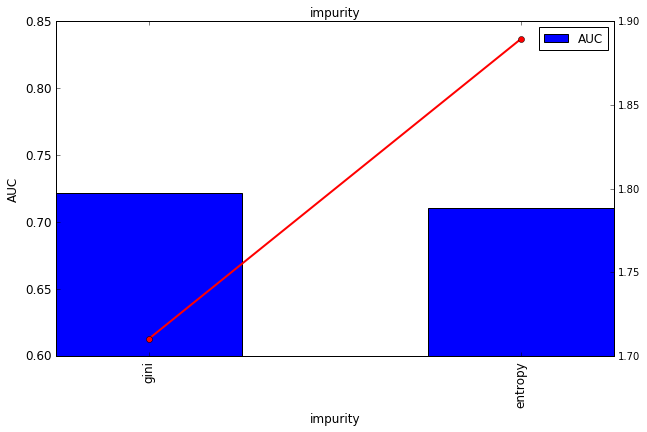

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.6,0.85])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
plt.show()

In [91]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

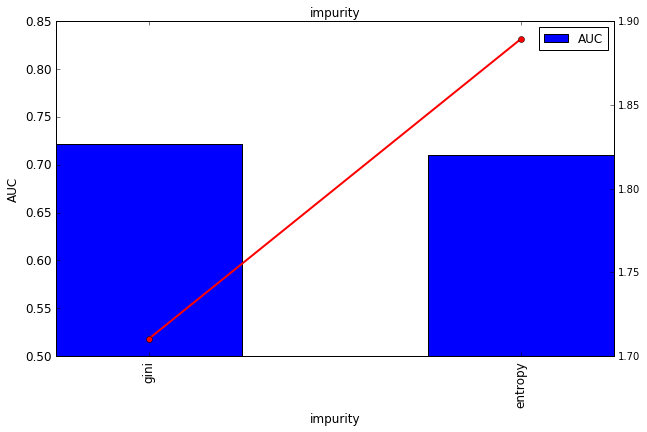

In [92]:
showchart(df,'impurity','AUC','duration',0.5,0.85 )

# 找出最好的評估參數

In [93]:
#定義evalParameter函數
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #訓練評估參數
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #設定目前評估的參數
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #轉換為Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #顯示圖形
    showchart(df,evalparm,'AUC','duration',0.5,0.9 )

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.40505099297 結果AUC = 0.721428571429
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.30560708046 結果AUC = 0.710317460317


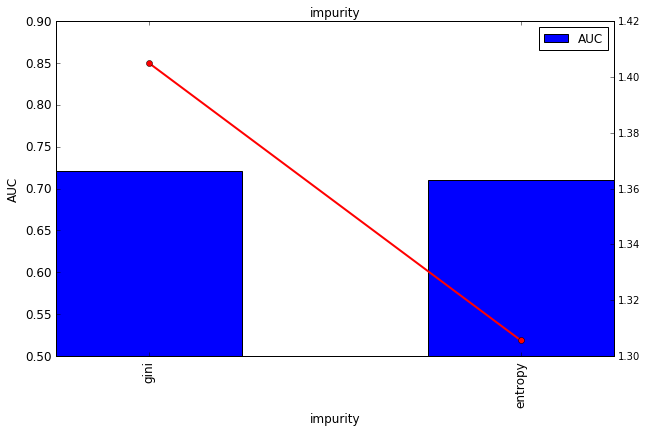

In [94]:
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10 ])  

訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.988341093063 結果AUC = 0.744444444444
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.983901977539 結果AUC = 0.723015873016
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.53067684174 結果AUC = 0.721428571429
訓練評估：使用參數 impurity=gini maxDepth=15 maxBins=10
 ==>所需時間=1.46686196327 結果AUC = 0.721428571429
訓練評估：使用參數 impurity=gini maxDepth=20 maxBins=10
 ==>所需時間=1.67483091354 結果AUC = 0.721428571429
訓練評估：使用參數 impurity=gini maxDepth=25 maxBins=10
 ==>所需時間=1.65889191628 結果AUC = 0.721428571429


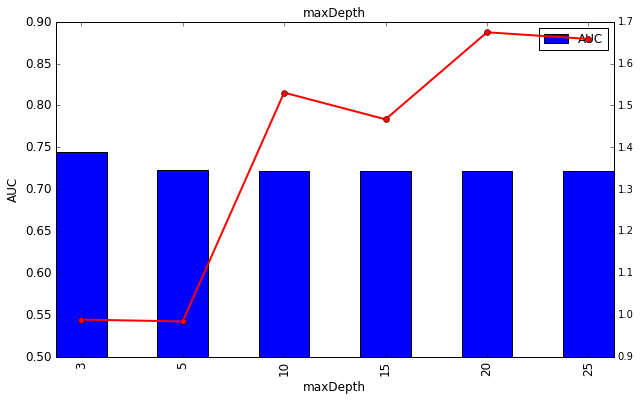

In [95]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=3
 ==>所需時間=1.39385890961 結果AUC = 0.765079365079
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=1.20634698868 結果AUC = 0.707936507937
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.16472601891 結果AUC = 0.721428571429
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=50
 ==>所需時間=1.23221707344 結果AUC = 0.765873015873
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=100
 ==>所需時間=1.13673305511 結果AUC = 0.777777777778
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=200
 ==>所需時間=1.41366100311 結果AUC = 0.742857142857


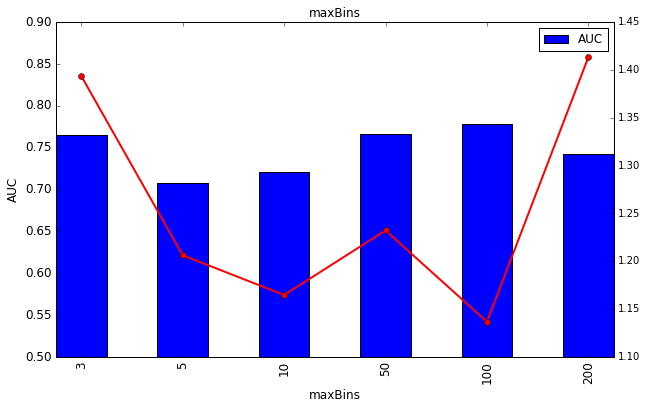

In [96]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

In [97]:
#定義evalAllParameter函數
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for迴圈訓練評估所有參數組合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的參數組合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #顯示調校後最佳參數組合      
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    結果AUC = " + str(bestParameter[0]))
    #傳回最佳模型
    return bestParameter[5]

In [98]:
    print("-----所有參數訓練評估找出最好的參數組合---------")  
    bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])

-----所有參數訓練評估找出最好的參數組合---------
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=3
 ==>所需時間=0.77072095871 結果AUC = 0.743650793651
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=5
 ==>所需時間=0.882483005524 結果AUC = 0.720634920635
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.799427032471 結果AUC = 0.744444444444
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=50
 ==>所需時間=0.811955928802 結果AUC = 0.743650793651
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=100
 ==>所需時間=0.743755102158 結果AUC = 0.719841269841
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=200
 ==>所需時間=0.726273775101 結果AUC = 0.743650793651
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=3
 ==>所需時間=0.865481138229 結果AUC = 0.811904761905
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=5
 ==>所需時間=0.815466880798 結果AUC = 0.756349206349
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.842834949493 結果AUC = 0.723015873016
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=50
 ==>所需時間=0.901010036469 結果AUC = 0.729365079365
訓練評估：使用參數 impurity=gini maxDepth=5 maxBin

In [99]:
#確認傳回的最佳模型是否有overfitting的問題
AUC=evaluateModel(model, testData)
print "AUC="+str(AUC)

AUC=0.813596491228
